In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [42]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import precision_score, recall_score
import eli5
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df1_test = pd.read_csv('../data/ht_match_na.csv')
df2_test = pd.read_csv('../data/ht_match_ind_na.csv')

df = df_join(df1,df2)
df_test = df_join(df1_test, df2_test)

In [8]:
y = df['win']
X = df.drop(columns=['match_id','win'])

X_cols = X.columns

#### Converting team names ('red', 'blue') to 1 and 0

In [9]:
mask = {'blue':0,'red':1}
X['teams'] = X['teams'].replace(mask)

df_test['teams'] = df_test['teams'].replace(mask)

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [11]:
num_features, cat_features = feature_separator(X)

In [12]:
scaled_pl = pipeline(True,num_features,False, True)
unscaled_pl = pipeline(True,num_features,False, False)

In [13]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [14]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.92
Recall score for scaled log reg: 0.87


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.91
Recall score for unscaled random forest: 0.89


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.91
Recall score for scaled gradient boost: 0.88


Mean cross validatin score for scaled Bayesian: 0.84
Precision score for scaled Bayesian: 0.85
Recall score for scaled Bayesian: 0.83




## Comparing ROC AUC Curves for base models

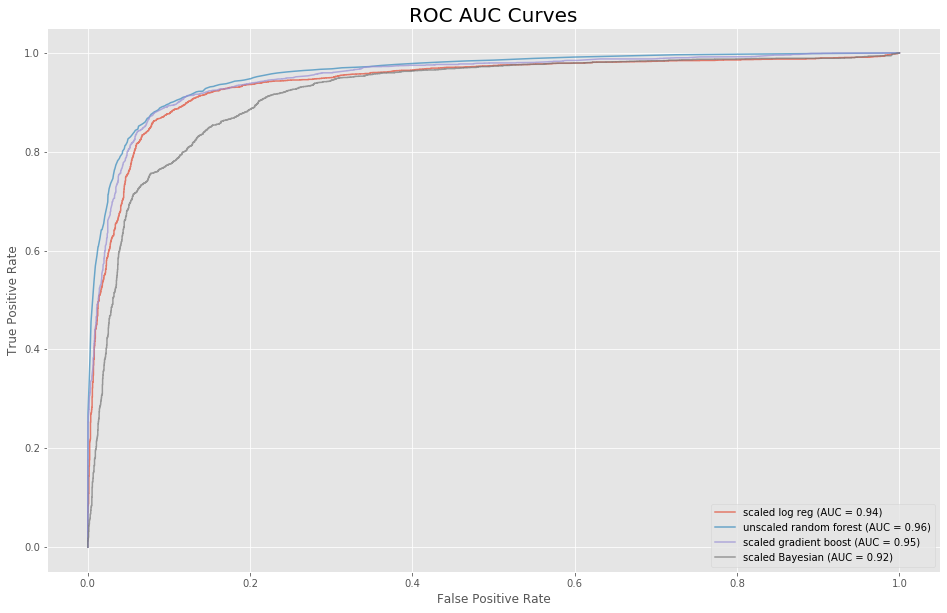

In [15]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X, y)

## Feature importances

## Tuning hyperparameters

In [22]:
params = {'estimator__n_estimators': (100, 200, 500),
         'estimator__max_depth': (3,5,8,None),
         'estimator__max_features': (3,6,'auto'),
         }

best_model = param_tuner(rfc_u,params,X,y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  8.1min finished


Best hyperparameters: {'estimator__max_depth': 8, 'estimator__max_features': 6, 'estimator__n_estimators': 200}


## CV score against the entire training dataset

In [23]:
clf = {'best_model':best_model}

model_scorer(clf,X_train,y_train, X_validation,y_validation)

Mean cross validatin score for best_model: 0.90
Precision score for best_model: 0.91
Recall score for best_model: 0.89




## Using the best model against the test dataset
##### Fit the best model with the training dataset and predict based on the test dataset

In [24]:
X_test = df_test[X_cols]
y_test = df_test['win']

In [25]:
pred = best_model.fit(X,y).predict(X_test)

## Result

In [26]:
print(f'The precision score: {precision_score(y_test,pred):.2f}')

The precision score: 0.90


In [55]:
print("Feature importances:")
weight_explainer(best_model,list(X_cols))

Feature importances:


Weight,Feature
0.4978 ± 0.2647,xp
0.1545 ± 0.1982,level
0.0730 ± 0.1306,totalKills
0.0643 ± 0.0785,firstBaron
0.0524 ± 0.0755,firstBlood
0.0458 ± 0.0689,firstTower
0.0445 ± 0.0532,teams
0.0236 ± 0.0673,totalDeaths
0.0182 ± 0.0240,firstInhibitor
0.0165 ± 0.0305,firstDragon
